## Project Reinforcement Learning 

Group 7 - Willem Huijzer, Joris Holshuijsen, Max Feucht


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Setting up the environment:

- 50kWh of usable capacity 
- 90% efficiency of the battery (both ways)
- The maximum power available is 25kW (both ways - pertains to charging and discharging. One hour, we charge and discharge 25kWh) 
- Prices are in MWh! --> Rescale
- Electricity is sold at the spot market price
- Electricity is bought at twice the price to pay for the transmission costs and various taxes.
- Only data up to the current time step available
- Day: 8am to 6pm
- Night: 6pm - 8am
- 50% of days, car is not available during the day and returns with 20kWh less
- Minimum capacity at 8am: 20kWh (if charge < 20kwH, charge from 7am to 8am)


### Open Questions:

- Intensity at which to sell or buy (Always 25kW, does it make sense to sell / buy less over a longer period of time)
- What reward to give when trying to charge / sell during the day when car is absent. Do we give a penalty for even trying or do we let it do whatever it wants?

In [4]:
# Load Data

def elongate(df):
    df_long = pd.wide_to_long(df, i = "PRICES", j = "hour", stubnames=["Hour"], sep = " ").reset_index()
    df_long.rename(columns={"Hour": "price", "PRICES": "date"}, inplace = True)
    df_long['datetime'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    df_long.sort_values(['datetime'], ascending=[True], inplace=True)
    return df_long

train = elongate(pd.read_excel('data/train.xlsx'))
val = elongate(pd.read_excel('data/validate.xlsx'))


In [7]:
import gym_env
env = gym.make('gym_env/BatteryGrid-v0')

env.set_data(train)

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_data to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_data` for environment variables or `env.get_wrapper_attr('set_data')` that will search the reminding wrappers.
  logger.warn(


In [12]:
class PriceIteration():
    
    def __init__(self, df, env, low_quantile = 0.25, high_quantile = 0.75, price_horizon = 100, verbose = False):
        self.df = df
        self.env = env
        self.low_quantile = low_quantile
        self.high_quantile = high_quantile
        self.price_horizon = price_horizon
        self.verbose = verbose
        
        
    
    def iterate(self, iterations = 1000):
        """
        Iterate through data and take actions based on price quantiles as a function of the price horizon
        """
        
        self.data = self.df[:iterations]
        
        self.battery_charge = []
        self.rewards = []

        self.env.reset()
        o,r,t,info = self.env.step(0)

        for i in range(len(self.data)):
            
            if o['prices'][-1] < np.quantile(o['prices'][-self.price_horizon:], self.low_quantile):
                action = 0
            elif o['prices'][-1] > np.quantile(o['prices'][-self.price_horizon:], self.low_quantile) and o['prices'][-1] < np.quantile(o['prices'][-self.price_horizon:], self.high_quantile):
                action = 2
            elif o['prices'][-1] >  np.quantile(o['prices'][-self.price_horizon:], self.high_quantile):
                action = 1
            else:
                action = np.random.randint(0,3)
            
            self.battery_charge.append(o['battery'])
            self.rewards.append(r)
            
            o,r,t,info = env.step(action)
            
            if t:
                break
        
        
    
    def normalize(self, data):
        """
        Helper function to normalize data
        """
        return ((data - np.min(data)) / (np.max(data) - np.min(data)))
    
    
    
    def normalize_data(self):
        """
        Normalizes data acquired from iteration
        """
        
        self.battery_charge = self.normalize(np.array(self.battery_charge))
        self.rewards = self.normalize(np.array(self.rewards))
        self.prices = self.normalize(np.array(self.data['price']))
        self.cumulative_reward = self.normalize(np.cumsum(self.rewards))
        
        
        
    def plot(self, cum = False):
        
        """ 
        Plots battery charge, reward, price, and cumulative reward (if cum = True)
        """
        
        self.normalize_data()
        
        plt.figure(figsize=(15,5))
        vars = [self.battery_charge, self.rewards, self.prices]
        var_names = ['Battery Charge', 'Reward', 'Price']
        if cum: 
            vars.append(self.cumulative_reward)
            var_names.append('Cumulative Reward')
            
        for var in vars:
            plt.plot(self.data['datetime'], var)
            
        plt.xticks(rotation=45)
        plt.legend(var_names)
        plt.show()
        
        
            
        

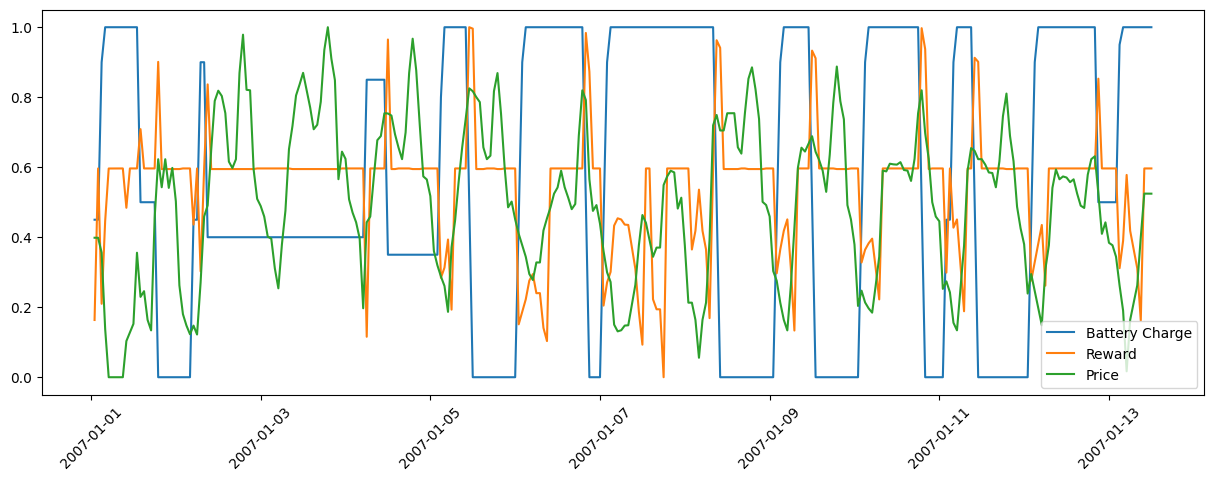

In [18]:
iterator = PriceIteration(train, env)
iterator.iterate(iterations = 300)
iterator.plot(cum = False)

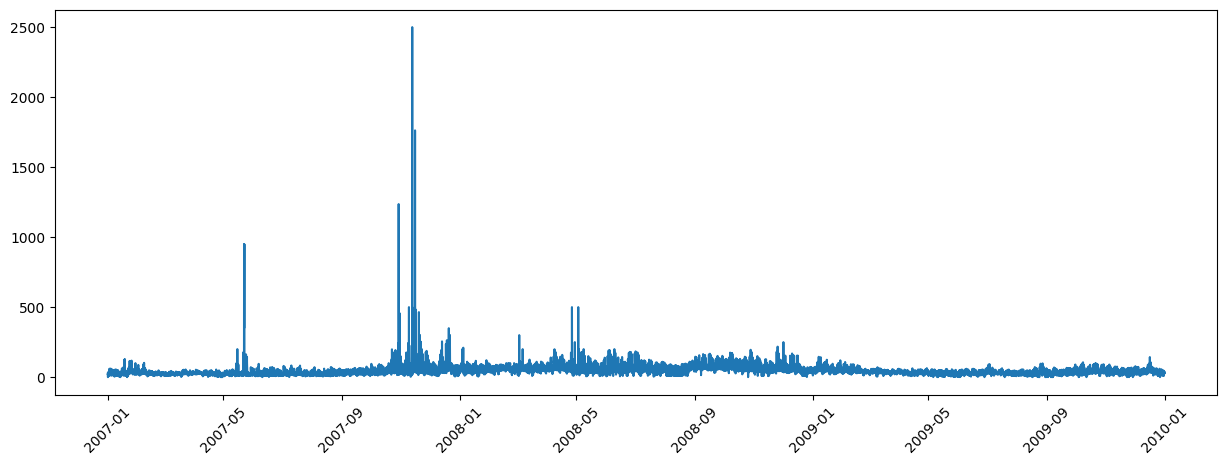

In [51]:
plt.figure(figsize=(15,5))
plt.plot(train['datetime'], train['price'])
plt.xticks(rotation=45)
plt.show()

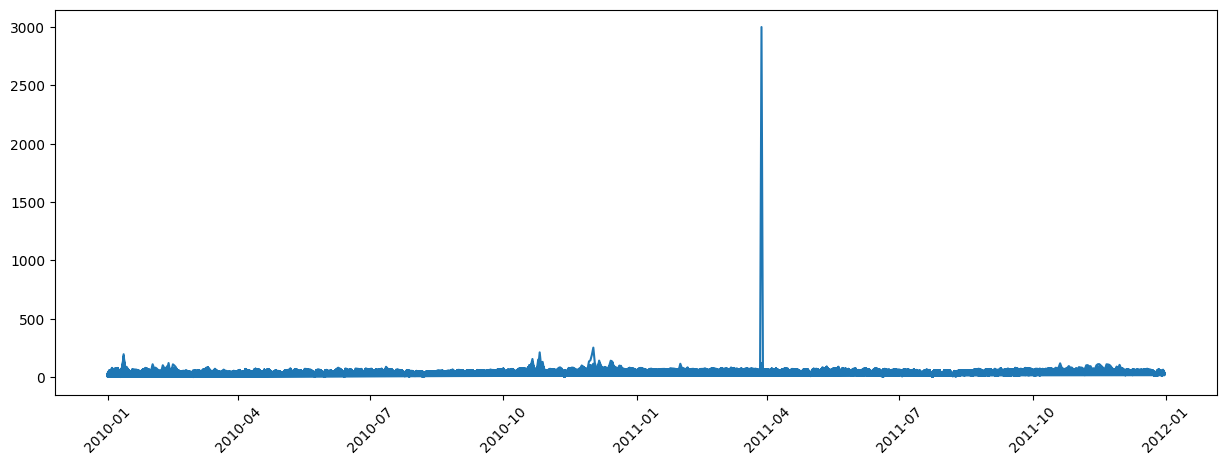

In [32]:
## Plot data
plt.figure(figsize=(15,5))
plt.plot(val['date'], val['price'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
## Rule-based Agent:



In [ ]:
# Feature Engineering: 

# ⁠Gradient of curve 
# Value of to same date last year if available 
# ⁠Moving average on different scale
# ⁠⁠Moving standard deviation  on different scales 
# ⁠⁠Season
# ⁠Day of week
# ⁠⁠Month
# Average historic hourly price
# Hardcoded price boundary (sell when price at previous timestep above threshold, buy when price at previous timestep is below threshold) - this can be a dynamic boundary (per month, per day, …) or a hard boundary 
